# Block Neural Autoregressive Flows

Apparently this is also a universal density approximator, but a more efficient parametrization as it also has vcompeteitive results, but with fewer parameters.

Personally, I was interested in understanding this architecvture since it was  the starting point for HCNAF and its repo seemed more accessible than the one(s) published with the NAF paper.


In [625]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import trange, tqdm
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal

import sys
sys.path.append("../../BNAF")
from bnaf import *
from toy2d import compute_log_p_x

#from naf.distributions import Distr

sys.path.append("../code")
from AnalysisUtils import *

import torch
from torch.autograd import Variable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Let's try to fit the $m_{hh}$ distribution

The models defined in the toy2d module use the arg parser, so I'm recopying them and slightly modifying them here to help with this issue.


In [2]:
data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
df = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')

fullmassplane


In [171]:
def create_model(num_flows=1, num_layers=2, hidden_dim=50, dim=1, 
                 device='cpu', verbose=False):
    '''
    Inputs:
    - num_flows: # of flows to stack
    - num_layers: # of layers / flow
    - hidden_dim: a,b for the weight matrix  
    - dim: # of dimensions that we're trying to predict
    - verbose
    Returns: 
    - model: An instance of a pytorch Sequential model
    '''
    flows = []
    for f in range(num_flows):
        layers = []
        for _ in range(num_layers - 1):
            layers.append(MaskedWeight(dim * hidden_dim,
                                       dim * hidden_dim, dim=dim))
            layers.append(Tanh())

        flows.append(
            BNAF(*([MaskedWeight(dim, dim * hidden_dim, dim=dim), Tanh()] + \
                   layers + \
                   [MaskedWeight(dim * hidden_dim, dim, dim=dim)]),\
                 res='gated' if f < num_flows - 1 else False
            )
        )

        if f < num_flows - 1:
            flows.append(Permutation(dim, 'flip'))

    model = Sequential(*flows).to(device)
    
    if verbose:
        print('{}'.format(model))
        print('Parameters={}, n_dims={}'.format(sum((p != 0).sum() 
                                                    if len(p.shape) > 1 else torch.tensor(p.shape).item() 
                                                    for p in model.parameters()), 2))
    
    return model

In [172]:
model=create_model() #num_layers=1,hidden_dim=10)

In [670]:
class myDataset():
    
    def __init__(self, Ntrain=10000, cols=['m_hh'], cond_cols=[]):

        self.N = Ntrain
        
        d = len(cols)
        
        mask = (df.kinematic_region == 2) & (df.ntag == 2)
        m_hh = df.loc[mask,cols].values[:Ntrain].reshape(-1, d)

        # Take the log
        m_hh = np.log(m_hh)

        # Normalize
        scalarX = StandardScaler()
        scalarX.fit(m_hh)

        self.x = scalarX.transform(m_hh,copy=True).reshape(-1,d)
        self.scalarX = scalarX
        
        if len(cond_cols) > 0:
            
            y_unnorm = df[cond_cols].values[:Ntrain]
            y_log = np.log(y_unnorm)
        
            scalarY = StandardScaler()
            scalarY.fit(y_log)
            y = scalarY.transform(y_log,copy=True)

            self.y = y
            self.scalarY = scalarY
            self.cond = True
                
        else:
            self.cond = False
        
    def sampler(self, n):
        
        indices = np.random.choice(np.arange(self.N), n, replace=False)
        
        if self.cond:
            return torch.from_numpy( self.x[indices].astype('float32') ),\
                   torch.from_numpy( self.y[indices].astype('float32') )
        else:
            return torch.from_numpy( self.x[indices].astype('float32') )
        

Ok, atm the dataset is so small that I don't even need to use mini batches.

In [494]:
def train_density(model, optimizer, scheduler, x, nEpochs=700, 
                  batch_dim=10000, clip_norm=.1,device='cpu'):
    '''
    Inputs:
    - model:
    - optimizer:
    - scheduler:
    - x:
    - nEpochs:
    - batch_dim: 
    - clip_norm:
    
    '''
    
    losses = {k:[] for k in ['train', 'test0', 'test1', 'test2']}
    
    #iterator = trange(nEpochs) #, smoothing=0, dynamic_ncols=True)
    for epoch in range(nEpochs):

        x_mb = x.sampler(batch_dim)
        
        if type(x_mb) == tuple:
            xi = x_mb[0].to(device)
            yi = x_mb[1].to(device)
            x_mb = (xi,yi)
        else:
            x_mb = x_mb.to(device)
        
        loss = - compute_log_p_x(model, x_mb).mean()

        loss.backward() 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)

        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step(loss)

        losses['train'].append(loss.data.cpu().numpy())
        
        #iterator.set_postfix(loss='{:.2f}'.format(loss.data.cpu().numpy()), refresh=False)
 
        if epoch % 100 == 0:
        
            nTest = 5000
        
            for yi in range(3):
                
                # Sample from the modes in each class
                nmodesperdim = ex1.nModes[yi]
                grid = np.linspace(-5,5,nmodesperdim)
                grid = np.meshgrid(grid,grid)
                grid = np.concatenate([grid[0].reshape(nmodesperdim**2,1),
                                       grid[1].reshape(nmodesperdim**2,1)],1)

                probs = np.ones(nmodesperdim**2) / float(nmodesperdim**2)
                distr_list = [multivariate_normal(mean, 1/float(nmodesperdim*np.log(nmodesperdim))) for mean in grid]

                modeCounts = np.random.multinomial(nTest, probs)

                spl = []
                for j, distr in zip(modeCounts,distr_list):
                    spl.append(distr.rvs(j))

                spl = np.vstack(spl)
                
                xx = torch.from_numpy(spl.astype('float32')).to(device)
                yy = (yi*torch.ones(nTest).reshape(-1,1)).to(device)
                    
                x_mb = (xx,yy)
                
                test_loss = - compute_log_p_x(model, x_mb).mean()
        
                losses[f'test{yi}'].append(test_loss.data.cpu().numpy())
        
            C0, C1, C2 = losses['test0'][-1], losses['test1'][-1],losses['test2'][-1] 
            print(f'Epoch {epoch}/{nEpochs} NLL: C0={C0:.2f}, C1={C1:.2f}, C2={C2:.2f}')
    
    return losses

In [183]:
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [184]:
decay = 0.5
patience = 2000
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=decay,
                                                       patience=patience,
                                                       min_lr=5e-4, verbose=True,
                                                       threshold_mode='abs')

In [149]:
x = myDataset()

In [173]:
out,grad = model(x.sampler(100))

For this 1d ex, the dataset is small enough that I don't even need to mini-batch it, so I don't need many passes over the data.

In [185]:
train_density(model, optimizer, scheduler, x, 3, 10000)























  0%|          | 0/3 [00:00<?, ?it/s]





















 33%|███▎      | 1/3 [00:00<00:01,  1.94it/s, loss=3.82]





















 67%|██████▋   | 2/3 [00:01<00:00,  1.94it/s, loss=3.73]





















100%|██████████| 3/3 [00:01<00:00,  1.92it/s, loss=3.67]


The loss for this model is now *lower* than it was for NAF... At this point, I'm not sure if this means I'm overfitting or not though.

Check how well we've modelled the $m_{hh}$ distribution we were trying to fit.

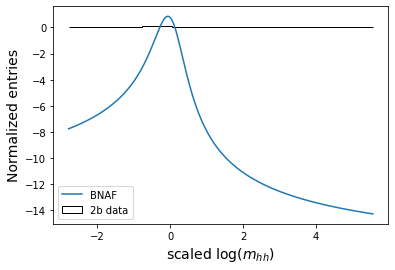

In [188]:
Nbins = 50
xlim = (np.min(x.x),np.max(x.x))

plt.hist(x.x,Nbins,xlim,histtype='step',color='k',label='2b data',#density=True)
         weights=np.ones_like(x.x)*1e-4)

res=200
xi = np.linspace(*xlim,res)

X = Variable(torch.from_numpy(xi.reshape(-1,1).astype('float32')))
px = np.exp(compute_log_p_x(model, X).data.numpy())
Z = compute_log_p_x(model, X).data.numpy()

dx = xi[1:] - xi[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])

N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xi,Z,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)

plt.show()

In [187]:
N

0.16736473929481097

Ok, this is *awesome*, the density is definitely getting estimated, and isn't overfitting as badly!!

I could continue playing with hyperparameters, but I think rn what I really should be looking towards is the conditional density estimation.

But, I think that it was awesome that I got to struggle with this a bit, because it's making me more equipped for dealing with the conditional density estimation problem :)

## Step 2: Reimplement the toy Gaussian experiments from HCNAF

So App B of their paper details the hyperparameters that they were using for their studies.

- 2 hidden layers
- 64 hidden units / layer
- batch size 64
- The hypernetwork used two MLPs with $C\in \mathbf{R}^1$ and outputs $W$ and $B$, where each MLP had 1 hidden layer with ReLU activation
- They used the same optimizer parameters and scheduler as the BNAF paper: adam w/ $\alpha = 0.5$ with the learning rate decaying by a factor of 0.5 if the NLL hasn't decreased in the last 2000 iterations. 

I think as the starting point I'll use the code in bnaf.py, but modify it for the conditional distributions.

In [ ]:
from hcnaf import CondSequential, CondTanh, CondMaskedWeight, HCNAF, create_cond_model

In [595]:
class HCNAF(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for constructing a Block Neural 
    Normalizing Flow.
    """
    
    def __init__(self, *args, res: str = None):
        """
        Parameters
        ----------
        *args : ``Iterable[torch.nn.Module]``, required.
            The modules to use.
        res : ``str``, optional (default = None).
            Which kind of residual connection to use. ``res = None`` is no residual 
            connection, ``res = 'normal'`` is ``x + f(x)`` and ``res = 'gated'`` is
            ``a * x + (1 - a) * f(x)`` where ``a`` is a learnable parameter.
        """
        
        super(HCNAF, self).__init__(*args)
        
        self.res = res
        
        if res == 'gated':
            self.gate = torch.nn.Parameter(torch.nn.init.normal_(torch.Tensor(1)))
    
    def forward(self, inputs : torch.Tensor, cond_inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """
            
        outputs = inputs
        grad = None
        
        for module in self._modules.values():
            outputs, grad = module(outputs, cond_inputs, grad)
            grad = grad if len(grad.shape) == 4 else grad.view(grad.shape + [1, 1])
            
        assert inputs.shape[-1] == outputs.shape[-1]
    
        grad = grad.squeeze(-1).squeeze(-1)
        
        if self.res == 'normal':
            return inputs + outputs, torch.nn.functional.softplus(grad).sum(-1)
        elif self.res == 'gated':
            return self.gate.sigmoid() * outputs + (1 - self.gate.sigmoid()) * inputs, \
                (torch.nn.functional.softplus(grad + self.gate) - \
                 torch.nn.functional.softplus(self.gate)).sum(-1)
        else:
            return outputs, grad.sum(-1)
        
    def _get_name(self):
        return 'HCNAF(res={})'.format(self.res)
        
        

In [591]:
class CondMaskedWeight(torch.nn.Module):
    """
    Module that implements a linear layer with block matrices with positive diagonal blocks.
    Moreover, it uses Weight Normalization (https://arxiv.org/abs/1602.07868) for stability.
    """
    
    def __init__(self, 
                 in_features : int, 
                 out_features : int, 
                 dim : int, 
                 D_in : int = 2,
                 H: int = 16,
                 device='cpu'
                ):
        """
        Parameters
        ----------
        in_features : ``int``, required.
            The number of input features per each dimension ``dim``.
        out_features : ``int``, required.
            The number of output features per each dimension ``dim``.
        dim : ``int``, required.
            The number of dimensions of the input of the flow.
        D_in: ``int``, default 2
            The number of conditional inputs
        H: ``int``, default 16
            The hidden dim for the mlp defining the hypernetwork
        """
            
        super(CondMaskedWeight, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features 
        self.dim = dim
        self.D_in = D_in
        self.H = H
    
        mask_d = torch.zeros(out_features, in_features)
        for i in range(dim):
            mask_d[i * (out_features // dim):(i + 1) * (out_features // dim),
                   i * (in_features // dim):(i + 1) * (in_features // dim)] = 1
        self.register_buffer('mask_d', mask_d)
            
        mask_o = torch.ones(out_features, in_features)
        for i in range(dim):
            mask_o[i * (out_features // dim):(i + 1) * (out_features // dim),
                   i * (in_features // dim):] = 0
        self.register_buffer('mask_o', mask_o)

        # Define the hypernetwork that sets the parameters for the weight and bias vectors
        D_out = (dim*(dim+1) // 2) * (out_features // dim) * (in_features // dim)
        D_out += 2 * out_features
        model = torch.nn.Sequential(
                                    torch.nn.Linear(D_in, H),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(H, D_out),
                                   )
        
        self.model = model
        
    def get_weights(self, cond_inputs, batch_size):
        """
        Computes the weight matrix using masks and weight normalization.
        It also compute the log diagonal blocks of it.
        """
        
        cond_outputs = self.model(cond_inputs)
        
        # Fill the matrix W st the diagonal entries are positive
        #weight = torch.zeros(batch_size, self.out_features, self.in_features).to(self.device)
        weight = cond_inputs.new_full((batch_size, self.out_features, self.in_features), fill_value=0)
    
        q = self.out_features * self.in_features // self.dim
        weight[:,self.mask_d.bool()] = cond_outputs[:,:q]
        
        r = self.in_features*self.out_features*(self.dim+1) // (2* self.dim)
        weight[:,self.mask_o.bool()] = cond_outputs[:, q:r]
        
        w = torch.exp(weight) * self.mask_d + weight * self.mask_o
        
        # Ok, I'm trying taking out this weight normalization
        w_squared_norm = (w ** 2).sum(-1, keepdim=True)
        # The diagonal weight for the weight noramalization
        diag_weight = cond_outputs[:,r:r+self.out_features].unsqueeze(-1)
        w = diag_weight.exp() * w / w_squared_norm.sqrt()
        
        wpl = diag_weight + weight - 0.5 * torch.log(w_squared_norm) 
        
        # Fill the bias vector
        bias = cond_outputs[:,r+self.out_features:]
        
        return w.transpose(-2, -1), wpl.transpose(-2, -1)[:,self.mask_d.bool().t()].view(batch_size,
            self.dim, self.in_features // self.dim, self.out_features // self.dim), bias


    def forward(self, inputs, cond_inputs, grad : torch.Tensor = None):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        cond_inputs: ``torch.Tensor``, required
            The input tensor that we condition on
        grad : ``torch.Tensor``, optional (default = None).
            The log diagonal block of the partial Jacobian of previous transformations.
        Returns
        -------
        The output tensor and the log diagonal blocks of the partial log-Jacobian of previous 
        transformations combined with this transformation.
        """
        
        batch_size = inputs.shape[0]
        w, wpl, b = self.get_weights(cond_inputs,batch_size)
        
        # It's no longer necessary to need to repeat exs along the batch dim
        g = wpl.transpose(-2, -1)
        
        return inputs.unsqueeze(1).matmul(w).squeeze(1) + b, torch.logsumexp(
            g.unsqueeze(-2) + grad.transpose(-2, -1).unsqueeze(-3), -1) if grad is not None else g

    def __repr__(self):
        return 'CondMaskedWeight(in_features={}, out_features={}, dim={}, D_in={}, H={})'.format(
            self.in_features, self.out_features, self.dim, self.D_in, self.H)


**Mini-goal:** I just want to understand the shapes of these tensors and how they get modified by the masking operation.

In [381]:
dim=2
b=1
a=3

D_in, D_out = 2,50
H=16

in_features, out_features, dim = (dim*b, dim*a, dim)
bias = True
batch_size = 1000

In [214]:
model = torch.nn.Sequential(
                            torch.nn.Linear(D_in, H),
                            torch.nn.ReLU(),
                            torch.nn.Linear(H, D_out),
                           )

cond_inputs = torch.randn(batch_size,D_in)

cond_outputs = model(cond_inputs)
cond_outputs.shape

torch.Size([1000, 50])

In [215]:
xin = torch.randn(batch_size,dim)
cond_inputs = torch.randn(batch_size,D_in)

mw = CondMaskedWeight(dim*b, dim*a, dim=dim)
out, grad = mw(xin,cond_inputs,None)

In [216]:
out.shape

torch.Size([1000, 6])

In [217]:
grad.shape

torch.Size([1000, 2, 3, 1])

**Next step:** Create the conditional model

In [382]:
class CondSequential(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for computing the output of 
    the function alongside with the log-det-Jacobian of such transformation.
    """
    
    def forward(self, inputs : torch.Tensor, cond_inputs : torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """
        
        log_det_jacobian = 0.
        for i, module in enumerate(self._modules.values()):
            inputs, log_det_jacobian_ = module(inputs, cond_inputs)
            log_det_jacobian += log_det_jacobian_
        return inputs, log_det_jacobian


In [219]:
class CondTanh(torch.nn.Tanh):
    """
    Class that extends ``torch.nn.Tanh`` additionally computing the log diagonal
    blocks of the Jacobian.
    """

    def forward(self, inputs, cond_input: torch.Tensor = None, grad : torch.Tensor = None):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        grad : ``torch.Tensor``, optional (default = None).
            The log diagonal blocks of the partial Jacobian of previous transformations.
        Returns
        -------
        The output tensor and the log diagonal blocks of the partial log-Jacobian of previous 
        transformations combined with this transformation.
        """
        
        g = - 2 * (inputs - math.log(2) + torch.nn.functional.softplus(- 2 * inputs))
        return torch.tanh(inputs), (g.view(grad.shape) + grad) if grad is not None else g


In [370]:
def create_cond_model(num_flows=1, num_layers=2, hidden_dim=50, dim=1,
                      cond_dim=2, hypernet_h=16,
                      device='cpu', verbose=False):
    '''
    Inputs:
    - num_flows: # of flows to stack
    - num_layers: # of layers / flow
    - hidden_dim: a,b for the weight matrix  
    - dim: # of dimensions that we're trying to predict
    - cond_dim: The dimension of the conditioning space
    - batch_size: The batch_size (needed for the CondMaskedWeight network)
    - hypernet_h: The hidden dim defining the the dimension of the
                  mlp defining the (unconstrainesd) hypernetwork
    - verbose
    
    Returns: 
    - model: An instance of a pytorch Sequential model
    '''
    
    kwargs = {'dim': dim, 'H': hypernet_h, 'D_in': cond_dim, 'device':device}
    
    flows = []
    for f in range(num_flows):
        layers = []
        for _ in range(num_layers - 1):
            layers.append(CondMaskedWeight(dim * hidden_dim,
                                           dim * hidden_dim, **kwargs))
            layers.append(CondTanh())

        flows.append(
            HCNAF(*([CondMaskedWeight(dim, dim * hidden_dim, **kwargs), CondTanh()] + \
                   layers + \
                   [CondMaskedWeight(dim * hidden_dim, dim, **kwargs)]),\
                 res='gated' if f < num_flows - 1 else False
            )
        )

        if f < num_flows - 1:
            flows.append(Permutation(dim, 'flip'))

    model = CondSequential(*flows).to(device)
    
    if verbose:
        print('{}'.format(model))
        print('Parameters={}, n_dims={}'.format(sum((p != 0).sum() 
                                                    if len(p.shape) > 1 else torch.tensor(p.shape).item() 
                                                    for p in model.parameters()), 2))
    
    return model

In [232]:
x = torch.randn(batch_size,dim)
y = torch.randn(batch_size,2)

cond_model = create_cond_model(dim=dim,verbose=True)
out, grad = cond_model(x,y)

CondSequential(
  (0): HCNAF(res=False)(
    (0): CondMaskedWeight(in_features=2, out_features=100, dim=2, D_in=2, H=16)
    (1): CondTanh()
    (2): CondMaskedWeight(in_features=100, out_features=100, dim=2, D_in=2, H=16)
    (3): CondTanh()
    (4): CondMaskedWeight(in_features=100, out_features=2, dim=2, D_in=2, H=16)
  )
)
Parameters=139612, n_dims=2
batch_size 1000
batch_size 1000
batch_size 1000


Yey!! The forward evaluation mode works. Now I need to be able to train a model, so set up a Dataset for the toy Gaussian experiment.

**Dataset**

The details of this experiment come from the [NAF paper](https://arxiv.org/pdf/1804.00779.pdf).

On a 2D meshgrid [-5,5], they considered either 2, 5, or 10 modes in each dimension.

For the exact details of the distribution though, [this class](https://github.com/CW-Huang/naf_examples/blob/master/naf/distributions.py#L69-L81) in the naf_examples repo was useful.

In [485]:
class ToyGaussEx1():
    
    def __init__(self):

        self.nClasses = 3
        self.nModes = np.array([2,5,10])
        
    def sampler(self, n):
        
        
        # Step 1: Sample which of the classes you choose from,
        #         which is also what we'll be conditioning on.
        classCounts = np.random.multinomial(n, self.nModes**2 / np.sum(self.nModes**2))
        
        y = []
        x = []

        for yi, ni in enumerate(classCounts):

            y.append(np.ones(ni)*yi)

            # Sample from the modes in each class
            nmodesperdim = self.nModes[yi]
            grid = np.linspace(-5,5,nmodesperdim)
            grid = np.meshgrid(grid,grid)
            grid = np.concatenate([grid[0].reshape(nmodesperdim**2,1),
                                   grid[1].reshape(nmodesperdim**2,1)],1)

            probs = np.ones(nmodesperdim**2) / float(nmodesperdim**2)
            distr_list = [multivariate_normal(mean, 1/float(nmodesperdim*np.log(nmodesperdim))) for mean in grid]

            modeCounts = np.random.multinomial(ni, probs)
            
            for j, distr in zip(modeCounts,distr_list):
                x.append(distr.rvs(j))
                
        # Concatenate the lists
        y = np.concatenate(y).reshape(-1,1)
        x = np.vstack(x)
        
        indices = np.random.shuffle(np.arange(n))

        # Step 4: Cast to a torch tensor
        return torch.from_numpy(x.astype('float32')), torch.from_numpy(y.astype('float32'))

In [486]:
ex1 = ToyGaussEx1()

Define settings for the experiment.

In [489]:
learning_rate = 5e-3
decay = 0.5
patience = 50 #12

In [581]:
device='cuda:0'
m1 = create_cond_model(dim=2,cond_dim=1,hidden_dim=64,
                       hypernet_h=16,
                       device=device)

o1 = optimizer = torch.optim.Adam(m1.parameters(), lr=learning_rate) #, amsgrad=True)

s1 = torch.optim.lr_scheduler.ReduceLROnPlateau(o1, factor=decay,
                                                patience=patience,
                                                min_lr=1e-4, verbose=True,
                                                threshold_mode='abs')

Train the model

In [558]:
xi,yi = ex1.sampler(10)

In [559]:
xi.shape


torch.Size([10, 2])

In [560]:
yi.shape

torch.Size([10, 1])

In [582]:
m1.to(device)
losses = train_density(m1, o1, s1, ex1, nEpochs=2000, 
                       batch_dim=1024, device=device)

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([5000, 2])
w torch.Size([5000, 2, 128])
b torch.Size([5000, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([5000, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([5000, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
torch.Size([1024, 128])
torch.Size([1024, 128])
inputs torch.Size([1024, 128])
w torch.Size([1024, 128, 2])
b torch.Size([1024, 2])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 2])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 2])
torch.Size([1024, 2])
inputs torch.Size([1024, 2])
outputs torch.Size([1024, 2])
inputs torch.Size([1024, 2])
w torch.Size([1024, 2, 128])
b torch.Size([1024, 128])
inputs.unsqueeze(1).matmul(w) torch.Size([1024, 1, 128])
inputs.unsqueeze(1).matmul(w).squeeze() torch.Size([1024, 128])
tor

KeyboardInterrupt: 

Take a look at the results

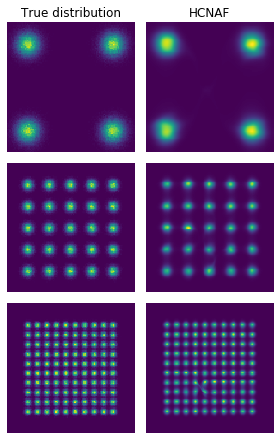

In [502]:
res=150
rng=[(-7.5,7.5),(-7.5,7.5)]

x = np.linspace(rng[0][0], rng[0][1], res)
y = np.linspace(rng[1][0], rng[1][1], res)
xx,yy = np.meshgrid(x,y)
X = np.concatenate((xx.reshape(res**2,1),yy.reshape(res**2,1)),1)
X = X.astype('float32')
X = Variable(torch.from_numpy(X))

fig,axes = plt.subplots(3,2,figsize=(4,6))

for yi, (ax1, ax2) in enumerate(axes):
    
    '''
    Plot the True dist
    '''
    # Sample from the modes in each class
    nmodesperdim = ex1.nModes[yi]
    grid = np.linspace(-5,5,nmodesperdim)
    grid = np.meshgrid(grid,grid)
    grid = np.concatenate([grid[0].reshape(nmodesperdim**2,1),
                           grid[1].reshape(nmodesperdim**2,1)],1)

    probs = np.ones(nmodesperdim**2) / float(nmodesperdim**2)
    distr_list = [multivariate_normal(mean, 1/float(nmodesperdim*np.log(nmodesperdim))) for mean in grid]

    modeCounts = np.random.multinomial(10*res**2, probs)
    
    spl = []
    for j, distr in zip(modeCounts,distr_list):
        spl.append(distr.rvs(j))
        
    spl = np.vstack(spl)
    true_xs = spl[:,0]
    true_ys = spl[:,1]
    ax1.hist2d(true_xs, true_ys, 100, range=rng)
    
    '''
    Plot the predicted distribution
    '''
    Y = Variable(yi*torch.ones(res**2).reshape(-1,1))
    m1.to('cpu')

    Z = compute_log_p_x(m1, (X,Y)).data.numpy().reshape(res,res)

    ax2.pcolormesh(xx,yy,np.exp(Z))
    
    for ax in [ax1,ax2]:
        ax.axis('off')
        ax.set_xlim(rng[0])
        ax.set_ylim(rng[1])
    
fig.tight_layout()

# Add titles for the columns
axes[0,0].set_title('True distribution')
axes[0,1].set_title('HCNAF')
plt.savefig('figures/toyGaussian_HCNAF_ex1.pdf',bbox_inches='tight')
plt.show()

## Step 3: Make the $m_{hh}$ distribution conditional on the massplane

Create the dataset

In [508]:
df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'pairing_score_1', 'pairing_score_2', 'm_hh',
       'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2',
       'E_h2', 'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'angle_h1_j1', 'm_h1_j2',
       'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2',
       'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'BDT_d24_weight_16',
       'BDT_d24_weight_CRderiv_16'],
      dtype='object')

Try a first pass at training the model

In [510]:
def myTrainingLoop(model, optimizer, scheduler, x, nEpochs=700, 
                   batch_dim=10000, clip_norm=.1,device='cpu'):
    '''
    Inputs:
    - model:
    - optimizer:
    - scheduler:
    - x:
    - nEpochs:
    - batch_dim: 
    - clip_norm:
    
    '''
    
    
    iterator = trange(nEpochs) #, smoothing=0, dynamic_ncols=True)
    for epoch in iterator:

        x_mb = x.sampler(batch_dim)
        
        if type(x_mb) == tuple:
            xi = x_mb[0].to(device)
            yi = x_mb[1].to(device)
            x_mb = (xi,yi)
        else:
            x_mb = x_mb.to(device)
        
        loss = - compute_log_p_x(model, x_mb).mean()

        loss.backward() 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)

        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step(loss)

        iterator.set_postfix(loss='{:.2f}'.format(loss.data.cpu().numpy()), refresh=False)
 

In [686]:
device='cuda:1'
m2 = create_cond_model(dim=1,cond_dim=2,hidden_dim=64,
                       hypernet_h=16,
                       device=device)

o2 = optimizer = torch.optim.Adam(m2.parameters(), lr=learning_rate)

s2 = torch.optim.lr_scheduler.ReduceLROnPlateau(o2, factor=decay,
                                                patience=patience,
                                                min_lr=1e-4, verbose=True,
                                                threshold_mode='abs')

In [687]:
x_cond = myDataset(cond_cols=['m_h1','m_h2'])

In [688]:
myTrainingLoop(m2, o2, s2, x_cond, nEpochs=200, batch_dim=1024, device=device)















































  0%|          | 0/200 [00:00<?, ?it/s]













































  2%|▏         | 4/200 [00:00<00:05, 32.92it/s, loss=24.04]













































  4%|▍         | 8/200 [00:00<00:05, 34.19it/s, loss=16.57]













































  6%|▌         | 12/200 [00:00<00:05, 35.73it/s, loss=10.63]













































  8%|▊         | 17/200 [00:00<00:04, 37.20it/s, loss=5.61] 













































 11%|█         | 22/200 [00:00<00:04, 38.60it/s, loss=3.21]













































 14%|█▎        | 27/200 [00:00<00:04, 39.70it/s, loss=2.63]













































 16%|█▌        | 32/200 [00:00<00:04, 40.53it/s, loss=2.45]













































 18%|█▊        | 37/200 [00:00<00:03, 40.88it/s, loss=2.42]













































 21%|██        | 42/200 [00

Epoch   191: reducing learning rate of group 0 to 2.5000e-03.


Ok, interestingly, the loss of this conditional model is lower than with the unconditional NAF model, this seems promising, not sure how it will play out in practice tho.

**Evaluate the model in the SB**

Plan: Take the conditional points from the training dataset, and evaluate the $m_hh$ density

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


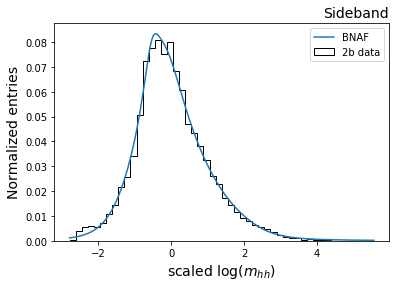

In [689]:
Nbins = 50
xlim = (np.min(x_cond.x),np.max(x_cond.x))

plt.hist(x_cond.x,Nbins,xlim,histtype='step',color='k',label='2b data',
         weights=np.ones_like(x_cond.x)*1e-4)

res=200
xx = np.linspace(*xlim,res)

Y = Variable(torch.from_numpy(x_cond.y.astype('float32')))
Y = Y.to(device)

px = []
for i,xi in enumerate(xx):
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{res}')
        
    X = Variable(torch.from_numpy(xi *np.ones((x_cond.N,1)).astype('float32')))
    X = X.to(device)
    px.append(np.exp(compute_log_p_x(m2, (X,Y)).cpu().data.numpy()))

px = np.vstack(px).mean(axis=1)

dx = xx[1:] - xx[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])
N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xx,N*px,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)
plt.title('Sideband',loc='right',fontsize=14)
#plt.savefig()
plt.show()

Wow! That actually performed pretty well out-of-the-box!

**Next:** Let's look at the extrapolation into the CR.

I can get this plot by retrieving 

Since I want to look at similar stats that I might see in the 4b sample, only look take 7000 of the 2b entries.

In [695]:
N_CR = 7000

CR = (df.kinematic_region == 1) & (df.ntag == 2)
mhh_CR = df.loc[CR,'m_hh'].values[:N_CR].reshape(-1, 1)

# Take the log and xform
mhh_CR = np.log(mhh_CR)
mhh_CR = x_cond.scalarX.transform(mhh_CR)

# Also get the conditional values
y_CR = df.loc[CR,['m_h1','m_h2']].values[:N_CR]

# Take the log and xform
y_CR = np.log(y_CR)
y_CR = x_cond.scalarY.transform(y_CR)

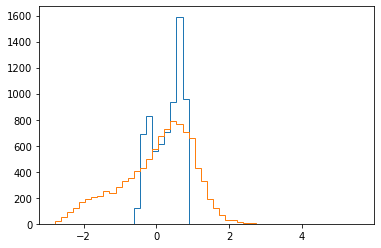

In [693]:
plt.hist(y_CR[:,0],Nbins,xlim,histtype='step')
plt.hist(x_cond.y[:,0],Nbins,xlim,histtype='step')
plt.show()

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


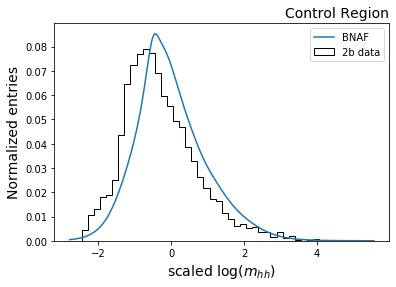

In [696]:
plt.hist(mhh_CR,Nbins,xlim,histtype='step',color='k',label='2b data',
         #density=True)
         weights=np.ones_like(mhh_CR)/N_CR)

res=200
xx = np.linspace(*xlim,res)

Y = Variable(torch.from_numpy(y_CR.astype('float32')))
Y = Y.to(device)

px = []
for i,xi in enumerate(xx):
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{res}')
        
    X = Variable(torch.from_numpy(xi *np.ones((N_CR,1)).astype('float32')))
    X = X.to(device)
    px.append(np.exp(compute_log_p_x(m2, (X,Y)).cpu().data.numpy()))

px = np.vstack(px).mean(axis=1)

dx = xx[1:] - xx[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])
N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xx,N*px,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)
plt.title('Control Region',loc='right',fontsize=14)

plt.show()

Ugh, the extrapolation isn't really working that well.

Perhaps it might be worth retrying with a model that doesn't sculpt the massplane as much?


So for the reweighting background estimate, Rafael saw that the estimate was improved when he also included the $p_T^{hh}$ variable - maybe also including this as a conditional input could help me as well?

In [697]:
df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'pairing_score_1', 'pairing_score_2', 'm_hh',
       'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2',
       'E_h2', 'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'angle_h1_j1', 'm_h1_j2',
       'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2',
       'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'BDT_d24_weight_16',
       'BDT_d24_weight_CRderiv_16'],
      dtype='object')

In [700]:
cond_cols = ['m_h1','m_h2','pt_hh']
x_3d = myDataset(cond_cols=cond_cols)

device='cuda:1'
m3 = create_cond_model(dim=1,cond_dim=len(cond_cols),hidden_dim=64,
                       hypernet_h=16,
                       device=device)

o3 = optimizer = torch.optim.Adam(m3.parameters(), lr=learning_rate)

s3 = torch.optim.lr_scheduler.ReduceLROnPlateau(o3, factor=decay,
                                                patience=patience,
                                                min_lr=1e-4, verbose=True,
                                                threshold_mode='abs')

myTrainingLoop(m3, o3, s3, x_3d, nEpochs=200, batch_dim=1024, device=device)
















































  0%|          | 0/200 [00:00<?, ?it/s]














































  2%|▏         | 4/200 [00:00<00:04, 39.55it/s, loss=28.92]














































  4%|▍         | 9/200 [00:00<00:04, 40.41it/s, loss=14.36]














































  7%|▋         | 14/200 [00:00<00:04, 41.45it/s, loss=6.85]














































 10%|▉         | 19/200 [00:00<00:04, 42.45it/s, loss=3.26]














































 12%|█▏        | 24/200 [00:00<00:04, 43.31it/s, loss=2.19]














































 14%|█▍        | 28/200 [00:00<00:04, 41.83it/s, loss=2.22]














































 16%|█▋        | 33/200 [00:00<00:04, 41.67it/s, loss=2.28]














































 19%|█▉        | 38/200 [00:00<00:03, 42.52it/s, loss=2.18]














































 22%|██▏       | 43

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


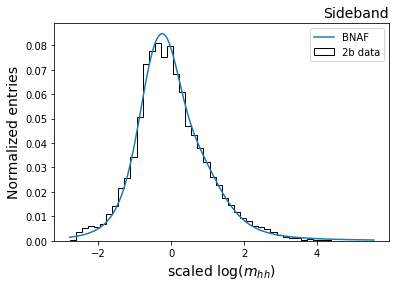

In [702]:
plt.hist(x_3d.x,Nbins,xlim,histtype='step',color='k',label='2b data',
         weights=np.ones_like(x_cond.x)*1e-4)

Y = Variable(torch.from_numpy(x_3d.y.astype('float32')))
Y = Y.to(device)

px = []
for i,xi in enumerate(xx):
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{res}')
        
    X = Variable(torch.from_numpy(xi *np.ones((x_3d.N,1)).astype('float32')))
    X = X.to(device)
    px.append(np.exp(compute_log_p_x(m3, (X,Y)).cpu().data.numpy()))

px = np.vstack(px).mean(axis=1)

dx = xx[1:] - xx[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])
N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xx,N*px,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)
plt.title('Sideband',loc='right',fontsize=14)
#plt.savefig()
plt.show()

Ok, still looks reaonsable in the sb.

In [703]:
# Get the conditional values and xform
y_CR = df.loc[CR,cond_cols].values[:N_CR]
y_CR = np.log(y_CR)
y_CR = x_3d.scalarY.transform(y_CR)

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


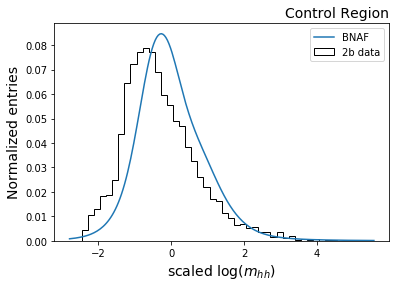

In [705]:
plt.hist(mhh_CR,Nbins,xlim,histtype='step',color='k',label='2b data',
         #density=True)
         weights=np.ones_like(mhh_CR)/N_CR)

res=200
xx = np.linspace(*xlim,res)

Y = Variable(torch.from_numpy(y_CR.astype('float32')))
Y = Y.to(device)

px = []
for i,xi in enumerate(xx):
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{res}')
        
    X = Variable(torch.from_numpy(xi *np.ones((N_CR,1)).astype('float32')))
    X = X.to(device)
    px.append(np.exp(compute_log_p_x(m3, (X,Y)).cpu().data.numpy()))

px = np.vstack(px).mean(axis=1)

dx = xx[1:] - xx[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])
N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xx,N*px,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)
plt.title('Control Region',loc='right',fontsize=14)

plt.show()

Last ditch attempt: What if we include all of the inputs in the model?

In [713]:
cond_cols = ['m_h1','m_h2','eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh']

x_all = myDataset(cond_cols=cond_cols)

device='cuda:1'
m4 = create_cond_model(dim=1,cond_dim=len(cond_cols),hidden_dim=64,
                       hypernet_h=16,
                       device=device)

o4 = torch.optim.Adam(m4.parameters(), lr=learning_rate)

s4 = torch.optim.lr_scheduler.ReduceLROnPlateau(o4, factor=decay,
                                                patience=patience,
                                                min_lr=1e-4, verbose=True,
                                                threshold_mode='abs')

myTrainingLoop(m4, o4, s4, x_all, nEpochs=1000, batch_dim=1024, device=device)
















































  0%|          | 0/1000 [00:00<?, ?it/s]














































  0%|          | 5/1000 [00:00<00:23, 43.07it/s, loss=13.94]














































  1%|          | 10/1000 [00:00<00:22, 43.88it/s, loss=8.07]














































  2%|▏         | 15/1000 [00:00<00:22, 44.60it/s, loss=3.85]














































  2%|▏         | 20/1000 [00:00<00:21, 45.13it/s, loss=2.43]














































  2%|▎         | 25/1000 [00:00<00:21, 45.53it/s, loss=2.11]














































  3%|▎         | 30/1000 [00:00<00:21, 45.87it/s, loss=2.12]














































  4%|▎         | 35/1000 [00:00<00:20, 46.12it/s, loss=2.03]














































  4%|▍         | 40/1000 [00:00<00:20, 46.31it/s, loss=1.81]














































  4%|▍    

 16%|█▋        | 165/1000 [00:03<00:17, 48.16it/s, loss=1.47]














































 17%|█▋        | 170/1000 [00:03<00:17, 48.13it/s, loss=1.47]














































 18%|█▊        | 175/1000 [00:03<00:17, 48.20it/s, loss=1.45]














































 18%|█▊        | 180/1000 [00:03<00:17, 48.21it/s, loss=1.42]














































 18%|█▊        | 185/1000 [00:03<00:16, 48.32it/s, loss=1.46]














































 19%|█▉        | 190/1000 [00:03<00:16, 48.30it/s, loss=1.41]














































 20%|█▉        | 195/1000 [00:04<00:16, 48.32it/s, loss=1.42]














































 20%|██        | 200/1000 [00:04<00:16, 48.28it/s, loss=1.41]














































 20%|██        | 205/1000 [00:04<00:16, 48.26it/s, loss=1.41]














































 21%|██        | 210/1000 [0

Epoch   259: reducing learning rate of group 0 to 2.5000e-03.

















































 27%|██▋       | 270/1000 [00:05<00:15, 48.29it/s, loss=1.41]














































 28%|██▊       | 275/1000 [00:05<00:15, 48.30it/s, loss=1.39]














































 28%|██▊       | 280/1000 [00:05<00:14, 48.33it/s, loss=1.38]














































 28%|██▊       | 285/1000 [00:05<00:14, 48.19it/s, loss=1.40]














































 29%|██▉       | 290/1000 [00:06<00:14, 48.04it/s, loss=1.34]














































 30%|██▉       | 295/1000 [00:06<00:14, 47.94it/s, loss=1.40]














































 30%|███       | 300/1000 [00:06<00:14, 47.87it/s, loss=1.40]














































 30%|███       | 305/1000 [00:06<00:14, 47.83it/s, loss=1.40]














































 31%|███       | 310/1000 [00:06<00:14, 47.76it/s, loss=1.38]





























Epoch   319: reducing learning rate of group 0 to 1.2500e-03.

















































 33%|███▎      | 330/1000 [00:06<00:14, 47.65it/s, loss=1.41]














































 34%|███▎      | 335/1000 [00:07<00:13, 47.80it/s, loss=1.37]














































 34%|███▍      | 340/1000 [00:07<00:13, 47.84it/s, loss=1.36]














































 34%|███▍      | 345/1000 [00:07<00:13, 48.00it/s, loss=1.37]














































 35%|███▌      | 350/1000 [00:07<00:13, 48.10it/s, loss=1.36]














































 36%|███▌      | 355/1000 [00:07<00:13, 48.18it/s, loss=1.41]














































 36%|███▌      | 360/1000 [00:07<00:13, 48.10it/s, loss=1.31]














































 36%|███▋      | 365/1000 [00:07<00:13, 48.25it/s, loss=1.38]














































 37%|███▋      | 370/1000 [00:07<00:13, 48.29it/s, loss=1.40]





























Epoch   408: reducing learning rate of group 0 to 6.2500e-04.

















































 42%|████▏     | 420/1000 [00:08<00:12, 47.80it/s, loss=1.39]














































 42%|████▎     | 425/1000 [00:08<00:12, 47.70it/s, loss=1.34]














































 43%|████▎     | 430/1000 [00:08<00:11, 47.78it/s, loss=1.35]














































 44%|████▎     | 435/1000 [00:09<00:11, 47.94it/s, loss=1.36]














































 44%|████▍     | 440/1000 [00:09<00:11, 47.97it/s, loss=1.36]














































 44%|████▍     | 445/1000 [00:09<00:11, 48.06it/s, loss=1.34]














































 45%|████▌     | 450/1000 [00:09<00:11, 48.09it/s, loss=1.32]














































 46%|████▌     | 455/1000 [00:09<00:11, 48.07it/s, loss=1.36]














































 46%|████▌     | 460/1000 [00:09<00:11, 48.08it/s, loss=1.36]





























Epoch   459: reducing learning rate of group 0 to 3.1250e-04.

















































 47%|████▋     | 470/1000 [00:09<00:10, 48.22it/s, loss=1.34]














































 48%|████▊     | 475/1000 [00:09<00:10, 48.26it/s, loss=1.34]














































 48%|████▊     | 480/1000 [00:10<00:10, 48.28it/s, loss=1.38]














































 48%|████▊     | 485/1000 [00:10<00:10, 48.32it/s, loss=1.34]














































 49%|████▉     | 490/1000 [00:10<00:10, 48.24it/s, loss=1.33]














































 50%|████▉     | 495/1000 [00:10<00:10, 48.22it/s, loss=1.32]














































 50%|█████     | 500/1000 [00:10<00:10, 48.33it/s, loss=1.41]














































 50%|█████     | 505/1000 [00:10<00:10, 48.18it/s, loss=1.34]














































 51%|█████     | 510/1000 [00:10<00:10, 48.16it/s, loss=1.39]





























Epoch   546: reducing learning rate of group 0 to 1.5625e-04.

















































 56%|█████▌    | 560/1000 [00:11<00:09, 45.69it/s, loss=1.32]














































 56%|█████▋    | 565/1000 [00:11<00:09, 45.90it/s, loss=1.38]














































 57%|█████▋    | 570/1000 [00:11<00:10, 42.87it/s, loss=1.29]














































 57%|█████▊    | 575/1000 [00:12<00:10, 41.72it/s, loss=1.32]














































 58%|█████▊    | 580/1000 [00:12<00:10, 41.98it/s, loss=1.33]














































 58%|█████▊    | 585/1000 [00:12<00:09, 42.21it/s, loss=1.38]














































 59%|█████▉    | 590/1000 [00:12<00:09, 42.33it/s, loss=1.35]














































 60%|█████▉    | 595/1000 [00:12<00:09, 42.48it/s, loss=1.32]














































 60%|██████    | 600/1000 [00:12<00:09, 42.55it/s, loss=1.31]





























Epoch   633: reducing learning rate of group 0 to 1.0000e-04.

















































 64%|██████▍   | 645/1000 [00:13<00:08, 42.69it/s, loss=1.37]














































 65%|██████▌   | 650/1000 [00:13<00:08, 42.66it/s, loss=1.34]














































 66%|██████▌   | 655/1000 [00:13<00:08, 42.74it/s, loss=1.32]














































 66%|██████▌   | 660/1000 [00:14<00:07, 42.72it/s, loss=1.32]














































 66%|██████▋   | 665/1000 [00:14<00:07, 42.69it/s, loss=1.37]














































 67%|██████▋   | 670/1000 [00:14<00:07, 42.66it/s, loss=1.31]














































 68%|██████▊   | 675/1000 [00:14<00:07, 42.66it/s, loss=1.29]














































 68%|██████▊   | 680/1000 [00:14<00:07, 42.62it/s, loss=1.30]














































 68%|██████▊   | 685/1000 [00:14<00:07, 42.70it/s, loss=1.36]





























 97%|█████████▋| 970/1000 [00:21<00:00, 42.75it/s, loss=1.30]














































 98%|█████████▊| 975/1000 [00:21<00:00, 43.20it/s, loss=1.31]














































 98%|█████████▊| 980/1000 [00:21<00:00, 43.75it/s, loss=1.35]














































 98%|█████████▊| 985/1000 [00:21<00:00, 44.41it/s, loss=1.32]














































 99%|█████████▉| 990/1000 [00:21<00:00, 44.91it/s, loss=1.32]














































100%|█████████▉| 995/1000 [00:21<00:00, 45.33it/s, loss=1.37]














































100%|██████████| 1000/1000 [00:21<00:00, 45.56it/s, loss=1.34]


In [714]:
y_CR = df.loc[CR,cond_cols].values[:N_CR]
y_CR = np.log(y_CR)
y_CR = x_all.scalarY.transform(y_CR)

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


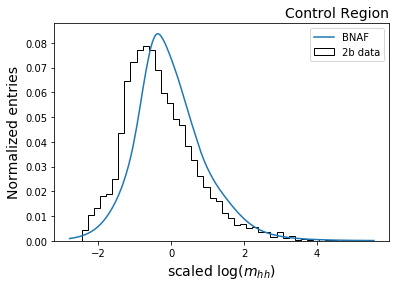

In [715]:
plt.hist(mhh_CR,Nbins,xlim,histtype='step',color='k',label='2b data',
         #density=True)
         weights=np.ones_like(mhh_CR)/N_CR)

res=200
xx = np.linspace(*xlim,res)

Y = Variable(torch.from_numpy(y_CR.astype('float32')))
Y = Y.to(device)

px = []
for i,xi in enumerate(xx):
    
    if (i+1) % 10 == 0:
        print(f'{i+1}/{res}')
        
    X = Variable(torch.from_numpy(xi *np.ones((N_CR,1)).astype('float32')))
    X = X.to(device)
    px.append(np.exp(compute_log_p_x(m4, (X,Y)).cpu().data.numpy()))

px = np.vstack(px).mean(axis=1)

dx = xx[1:] - xx[:-1]
mid_px = 0.5 * (px[1:] + px[:-1])
N = (xlim[1]-xlim[0]) / (np.sum(dx*mid_px)*Nbins)

plt.plot(xx,N*px,label='BNAF')

plt.legend()
plt.xlabel('scaled $\log ( m_{hh} )$',fontsize=14)
plt.ylabel('Normalized entries',fontsize=14)
plt.title('Control Region',loc='right',fontsize=14)

plt.show()

**Ideas:**
- Would including more points from outside of the SB would help?
- Maybe I should try increasing the number of training datapoints, or the complexity of the architecture?
- Or maybe a conditional NAF would perform better, perhaps its these hypernetworks that are overly sensitive to the interpolation problem?

I'm going to pause here and ask Michael for help at this point though.

In [717]:
len(df[df.ntag==2].index)

8076828

In [ ]:
len(df[df.ntag==2].index)